In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c
from py21cmfast import (
    AstroParams,
    CosmoParams,
    FlagOptions,
    UserParams,
    determine_halo_list,
    initial_conditions,
    perturb_field,
    plotting
    )

/opt/anaconda3/lib/python3.7/site-packages/py21cmfast/_cfg.py:50: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/opt/anaconda3/lib/python3.7/site-packages/py21cmfast/_cfg.py:32: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [ ]:
p21c.UserParams?

# Find halo locations, overplot onto density field

In [3]:
# Define user_params using UserParams(), flag_options with FlagOptions, astro_params with AstroParams
# Perturb field to redshift z = 8, obtain the halo list corresponding to this perturbed box, overplot onto
# density plot

user_params = UserParams(
    BOX_LEN=200, 
    HII_DIM=150,
    HMF=1,
    USE_INTERPOLATION_TABLES=True,
    PERTURB_ON_HIGH_RES=True,
    )

flag_options = FlagOptions(
    USE_MASS_DEPENDENT_ZETA=True,
    #USE_HALO_FIELD=True
    )

random_seed = 1234

'''
cosmo_params = CosmoParams(
    SIGMA_8=0.82, 
    hlittle=0.6774
    )

astro_params = AstroParams(
    HII_EFF_FACTOR=25.0,
    ALPHA_ESC=-0.5,
    ALPHA_STAR=0.5,
    F_ESC10=-1.30102999566,
    F_STAR10=-1.0,
    L_X=40.5,
    M_TURN=8.7,
    NU_X_THRESH=500.0,
    X_RAY_SPEC_INDEX=1.0,
    t_STAR=0.5,
    R_BUBBLE_MAX=15.0,
    )
'''

init_box = initial_conditions(
    user_params=user_params,
    #cosmo_params=cosmo_params,
    random_seed=random_seed,
    regenerate=True,
    write=False,
    )
    
redshift = 8.0

pt_box = perturb_field(
    redshift=redshift,
    init_boxes=init_box,
    user_params=user_params,
    #cosmo_params=cosmo_params,
    )

halos = determine_halo_list(
    redshift=redshift,
    init_boxes=init_box,
    user_params=user_params,
    #cosmo_params=cosmo_params,
    #astro_params=astro_params,
    flag_options=flag_options,
    regenerate=True,
    write=False,
    OPTIMIZE=False,
    )

list_halo_coords = halos.halo_coords

In [31]:
# Sort the halo masses in ascending order to breakdown according to mass

#halo_masses_to_sort = np.copy(halos.halo_masses)
#halo_masses_to_sort.sort()

In [33]:
#lowest_ten_index=len(halo_masses_to_sort)

7944863

In [35]:
# Make function to convert from voxel coordinates into distance coordinates

def vox_to_dist(box_len, HII_dim, vox_coords):
    dim = HII_dim*3
    dist_coords = (box_len/dim)*vox_coords + (box_len/dim)/2
    return dist_coords

Now that we have a list of the halo coordinates, we can overplot them onto a density field. 
When we are plotting a coeval_sliceplot we are showing a 2-D image (1 cell deep), 
therefore need to choose the halo coordinates to overplot. We do this by knowing the default index slice is 0,
and slice axis is along z-axis, so we simply filter our halo coordinates to only include those with z=0.
Now, given we are plotting a cross-sectional slice with units of Mpc, need to multiply by a factor to convert
the box number coordinates into distance coordinates; to convert from Box
coordinates to Mpc we do $\frac{\text{Box Length} [Mpc]}{\text{Dimension of Box} [No. Boxes]} * (\text{Box Number}) + \frac{\text{Box Length} [Mpc]}{2*\text{Dimension of Box} [No. Boxes]}$ to ensure Box Number = 0 shows up (given 0-index and taking $\text{Dimension of Box} = \text{HII Dimension} * 3$).

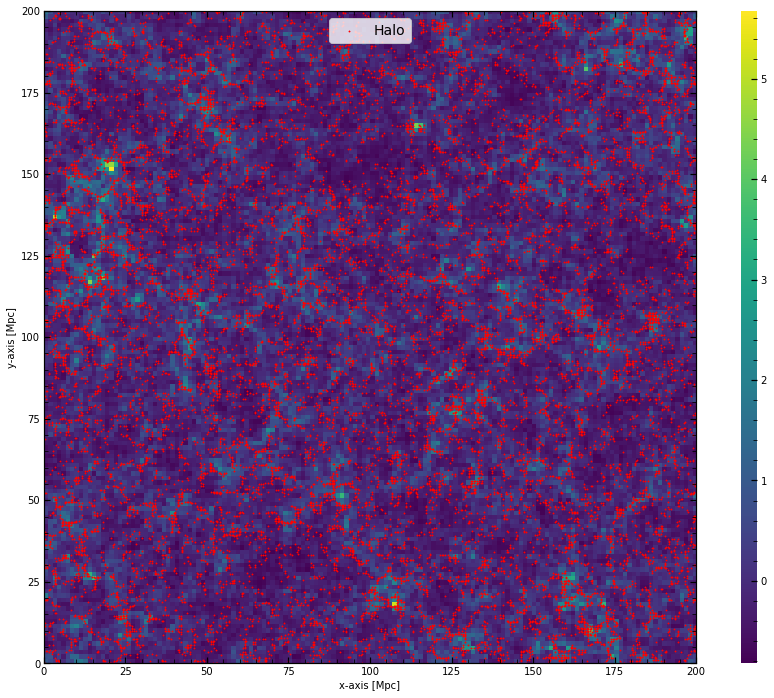

In [36]:
# Do the filtering of halo coords and box number to distance conversion, overplot onto coeval sliceplot

BOX_LEN = 200
HII_DIM = 150 # HII_DIM*3 = DIM

flat_halo_coords = list_halo_coords[list_halo_coords[:,2]==0]
dist_halo_coords = vox_to_dist(BOX_LEN, HII_DIM, flat_halo_coords)

fig, ax = plt.subplots(figsize=(16, 12))
ax.scatter(dist_halo_coords[:,0], dist_halo_coords[:,1], s=1, c='red', marker='*', label='Halo')
ax.legend(fontsize=14)
plotting.coeval_sliceplot(pt_box,kind='density',ax=ax,fig=fig);
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/high_res_halo_plot.jpeg')

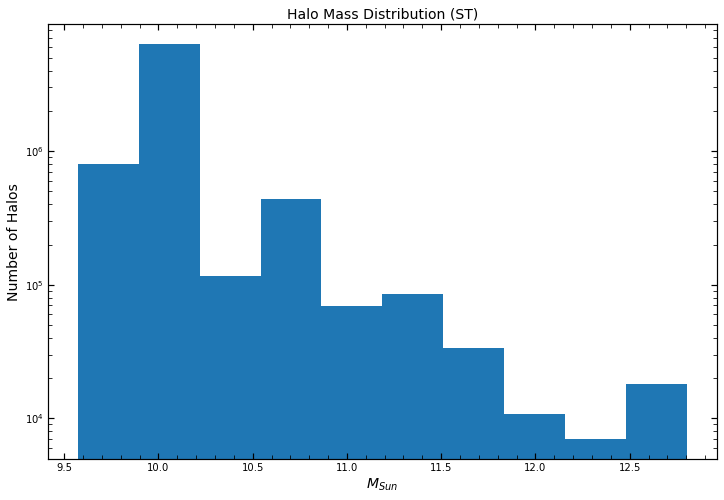

In [37]:
# Now we want to plot a histogram of the masses (over the whole cube)

fig, ax = plt.subplots(figsize=(12, 8))
halo_masses = halos.halo_masses
log_halo_masses=np.log10(halo_masses)
ax.hist(log_halo_masses)#, bins=1)#, density=True)
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('$M_{Sun}$', fontsize = 14)
ax.set_title('Halo Mass Distribution (ST)', fontsize = 14)
ax.set_ylabel('Number of Halos', fontsize = 14);
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/091321/halo_mass_distribution_logspace.jpeg')

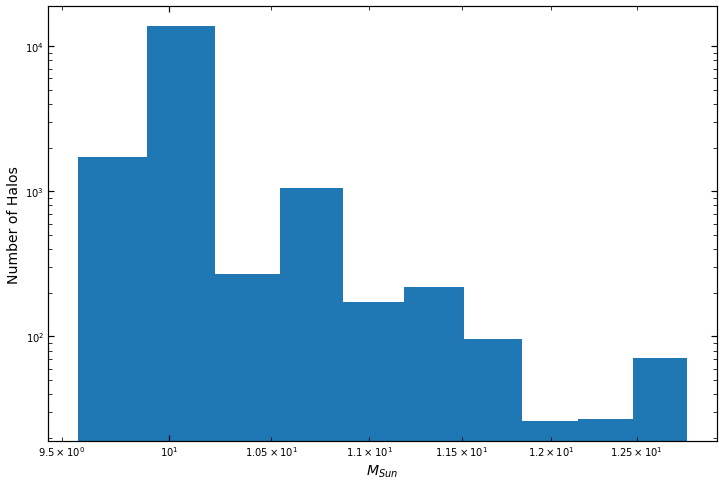

In [21]:
# Easier to visualize over a single slice due to smaller number of total haloes, take only z=0 slice

fig, ax = plt.subplots(figsize=(12, 8))
slice_halo_masses = halos.halo_masses[halos.halo_coords[:,2]==0]
slice_log_halo_masses = np.log10(slice_halo_masses)
ax.hist(slice_log_halo_masses)#, bins=1000),density=True)
ax.set_xlabel('$M_{Sun}$', fontsize = 14)
ax.set_ylabel('Number of Halos', fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')

In [38]:
# Filter halo coords belonging to each mass grouping (4 groupings separated by order of magnitude)

slice_halo_coords_mass10 = halos.halo_coords[(halos.halo_coords[:,2]==0) & (halos.halo_masses <1e10)]
slice_halo_coords_mass11 = halos.halo_coords[(halos.halo_coords[:,2]==0) & (halos.halo_masses >= 1e10) & (halos.halo_masses<1e11)]
slice_halo_coords_mass12 = halos.halo_coords[(halos.halo_coords[:,2]==0) & (halos.halo_masses >= 1e11) & (halos.halo_masses<1e12)]
slice_halo_coords_mass13 = halos.halo_coords[(halos.halo_coords[:,2]==0) & (halos.halo_masses >=1e12)]

In [39]:
slice_halo_coords_mass10.shape
slice_halo_coords_mass11.shape

(14601, 3)

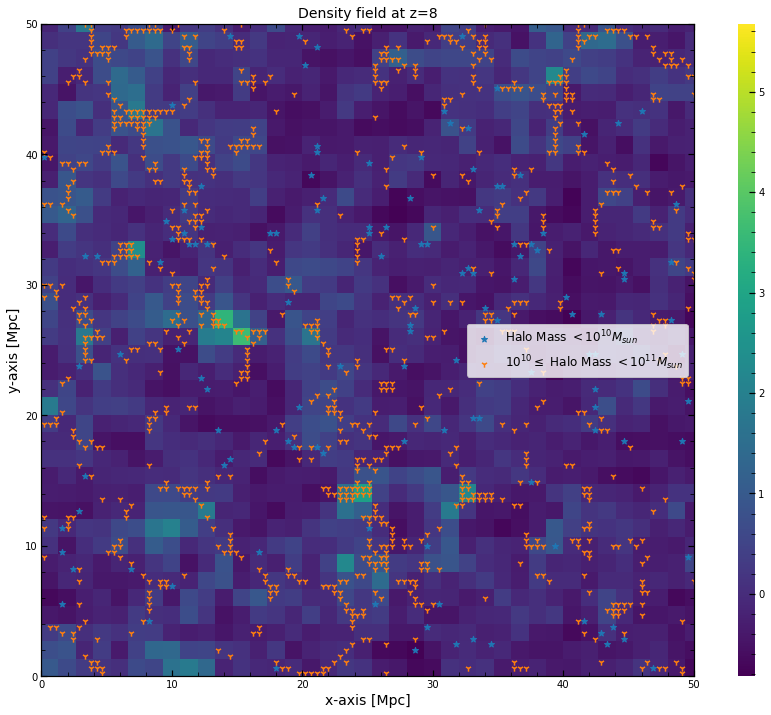

In [40]:
# Now convert to coords to distance coords, plot over a smaller slice (50Mpc x 50Mpc) to see halo groupings

BOX_LEN = 200
HII_DIM = 150.0 # HII_DIM*3 = DIM
dist_halo_coords_mass10 = vox_to_dist(BOX_LEN, HII_DIM, slice_halo_coords_mass10)
dist_halo_coords_mass11 = vox_to_dist(BOX_LEN, HII_DIM, slice_halo_coords_mass11)
dist_halo_coords_mass12 = vox_to_dist(BOX_LEN, HII_DIM, slice_halo_coords_mass12)
dist_halo_coords_mass13 = vox_to_dist(BOX_LEN, HII_DIM, slice_halo_coords_mass13)

#dist_halo_coords_mass12 = (BOX_LEN / (HII_DIM*3)) * slice_halo_coords_mass12 + (BOX_LEN / (HII_DIM*3))/2
#dist_halo_coords_mass13 = (BOX_LEN / (HII_DIM*3)) * slice_halo_coords_mass13 + (BOX_LEN / (HII_DIM*3))/2

fig, ax = plt.subplots(figsize=(16, 12))
ax.scatter(dist_halo_coords_mass10[:,0], dist_halo_coords_mass10[:,1], s=40,  marker='*', label='Halo Mass $< 10^{10} M_{sun}$')
ax.scatter(dist_halo_coords_mass11[:,0], dist_halo_coords_mass11[:,1], s=40,  marker='1', label='$10^{10} \leq$ Halo Mass $< 10^{11} M_{sun}$')
#ax.scatter(dist_halo_coords_mass12[:,0], dist_halo_coords_mass12[:,1], s=40,  marker='.', label='$10^{11} \leq$ Halo Mass $< 10^{12} M_{sun}$')
#ax.scatter(dist_halo_coords_mass13[:,0], dist_halo_coords_mass13[:,1], s=40,  marker='3', label='Halo Mass $> 10^{12} M_{sun}$')
ax.legend(fontsize=12)
ax.set_xlim(0,50)
ax.set_ylabel('y-axis [Mpc]',fontsize=14)
ax.set_xlabel('x-axis [Mpc]',fontsize=14)
ax.set_ylim(bottom=0,top=50)
ax.set_title('Density field at z=8', fontsize=14)
plotting.coeval_sliceplot(pt_box,kind='density',ax=ax,fig=fig);
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/091321/density_field_diff_halo_masses_zoom_out.jpeg')

In [88]:
# Now ionize this box, so we can again overplot our halos to see where they are relative to ionized bubbles

ionized=p21c.ionize_box(perturbed_field = pt_box)

In [89]:
# Function to get neutral/ionized coords and indices to plot mass distribution function

def get_neutral_coords(halo_low_res_coords, ionized_box):
    neutral_halo_coords = []
    neutral_halo_inds = []
    ionized_halo_coords = []
    ionized_halo_inds = []
    for i in range(len(halo_low_res_coords)):
        x = halo_low_res_coords[i][0]
        y = halo_low_res_coords[i][1]
        if ionized_box[x,y] == 1.0:
            neutral_halo_coords.append(np.array([x,y]))
            neutral_halo_inds += [i]
        else:
            ionized_halo_coords.append(np.array([x,y]))
            ionized_halo_inds += [i]
    return np.array(neutral_halo_coords),np.array(neutral_halo_inds), np.array(ionized_halo_coords), np.array(ionized_halo_inds)

In [90]:
# Now compute the neutral and ionized coords, and indices

new_flat_halo_coords = flat_halo_coords[:,:2] // 3
slice_ionized_box = ionized.xH_box[:,:,0]

neutral_halo_coords_slice, neutral_halo_inds_slice, ionized_halo_coords_slice, ionized_halo_inds_slice = get_neutral_coords(new_flat_halo_coords, slice_ionized_box)                                                                                                                                                                                                                                  
                                                                                                                            

In [101]:
# Get neutral/ionized halo coords in 450x450 slice and their masses

neutral_halo_coords = []
ionized_halo_coords = []
neutral_halo_masses = []
ionized_halo_masses = []
flattened_halo_coords = flat_halo_coords[:,:2]
flat_halo_masses = halos.halo_masses[halos.halo_coords[:,2]==0]

for i in neutral_halo_inds_slice:
    neutral_halo_coords.append(flattened_halo_coords[i])
    neutral_halo_masses += [flat_halo_masses[i]]
for j in ionized_halo_inds_slice:
    ionized_halo_coords.append(flattened_halo_coords[j])    
    ionized_halo_masses += [flat_halo_masses[j]]

In [102]:
# convert the list to numpy arrays

neutral_halo_coords = np.array(neutral_halo_coords)
ionized_halo_coords = np.array(ionized_halo_coords)
neutral_halo_masses = np.array(neutral_halo_masses)
ionized_halo_masses = np.array(ionized_halo_masses)

In [103]:
print(flat_halo_masses[i])

11756567000.0


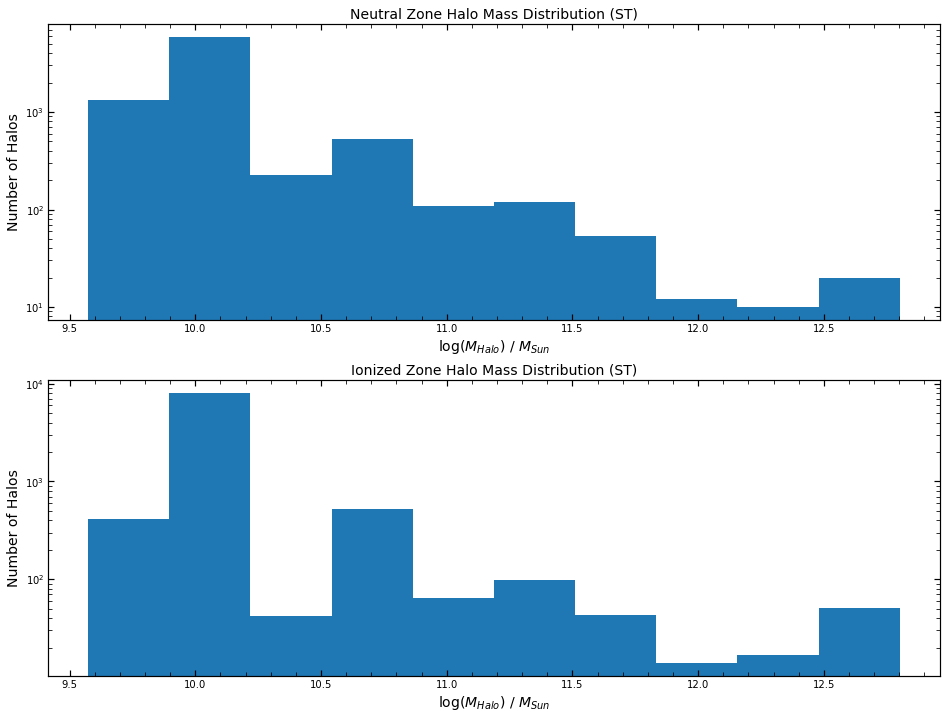

In [106]:
# Now we want to plot a histogram of the ionized and neutral halo masses

fig, ax = plt.subplots(2, figsize=(16, 12))
ax[0].hist(np.log10(neutral_halo_masses))#, bins=1000)#, density=True)
ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_xlabel('log($M_{Halo}$) / $M_{Sun}$', fontsize = 14)
ax[0].set_title('Neutral Zone Halo Mass Distribution (ST)', fontsize = 14)
ax[0].set_ylabel('Number of Halos', fontsize = 14);
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/091321/neutral_halo_mass_distribution.jpeg')
ax[1].hist(np.log10(ionized_halo_masses))#, bins=1000)#, density=True)
ax[1].set_yscale('log')
#ax[1].set_xscale('log')
ax[1].set_xlabel('log($M_{Halo}$) / $M_{Sun}$', fontsize = 14)
ax[1].set_title('Ionized Zone Halo Mass Distribution (ST)', fontsize = 14)
ax[1].set_ylabel('Number of Halos', fontsize = 14);
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/neutral_vs_ionized_halo_mass_distribution.jpeg')

In [107]:
# Now convert to distances and plot

neutral_dist_halo_coords = vox_to_dist(200, 150.0, neutral_halo_coords)
ionized_dist_halo_coords = vox_to_dist(200, 150.0, ionized_halo_coords)

In [96]:
slice_ionized_box = ionized.xH_box[:,:,0]
neutral_inds = np.where(slice_ionized_box == 1)
neutral_coords = np.array([[neutral_inds[0][i], neutral_inds[1][i]] for i in range(len(neutral_inds[0]))])

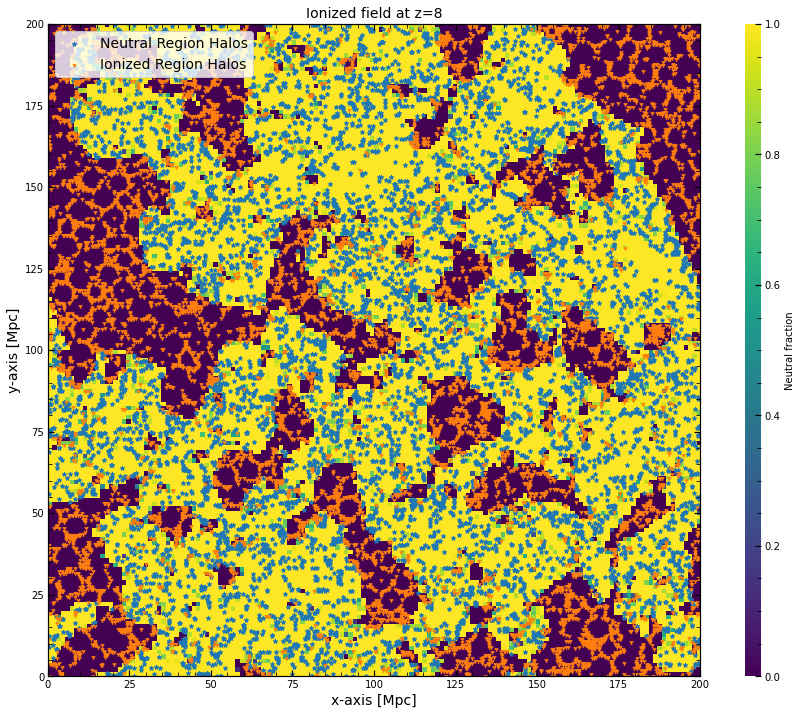

In [109]:
# Plot to verify it is only picking up the halos in neutral voxels

fig, ax = plt.subplots(figsize=(16, 12))
#halo_dist_neutral = vox_to_dist(200, 150, np.array(halo_coords_neutral))
ax.scatter(neutral_dist_halo_coords[:,0], neutral_dist_halo_coords[:,1], s=20,  marker='*', label = 'Neutral Region Halos')
ax.scatter(ionized_dist_halo_coords[:,0], ionized_dist_halo_coords[:,1], s=20,  marker='1', label = 'Ionized Region Halos')
#print(dist_halo_coords.shape)
#ax.scatter(dist_halo_coords[:,0], dist_halo_coords[:,1], s=20,  marker='*')
#ax.set_xlim(0,50)
ax.set_ylabel('y-axis [Mpc]',fontsize=14)
ax.set_xlabel('x-axis [Mpc]',fontsize=14)
ax.legend(fontsize=14)
#ax.set_ylim(bottom=0,top=50)
ax.set_title('Ionized field at z=8', fontsize=14)
plotting.coeval_sliceplot(ionized, "xH_box",ax=ax,fig=fig);
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/neutral_vs_ionized_halos.jpeg')

In [73]:
def vox_to_dist2(box_len, HII_dim, vox_coords):
    dim = HII_dim*3
    dist_coords = (box_len/dim)*vox_coords
    return dist_coords

In [ ]:
# Plot to verify it is only picking up the halos in neutral voxels

fig, ax = plt.subplots(figsize=(16, 12))
#halo_dist_neutral = vox_to_dist(200, 150, np.array(halo_coords_neutral))
ax.scatter(neutral_halo_distance_coords[:,0], neutral_halo_distance_coords[:,1], s=20,  marker='*', label = 'Neutral Region Halos')
ax.scatter(ionized_halo_distance_coords[:,0], ionized_halo_distance_coords[:,1], s=20,  marker='1', label = 'Ionized Region Halos')
#print(dist_halo_coords.shape)
#ax.scatter(dist_halo_coords[:,0], dist_halo_coords[:,1], s=20,  marker='*')
#ax.set_xlim(0,50)
ax.set_ylabel('y-axis [Mpc]',fontsize=14)
ax.set_xlabel('x-axis [Mpc]',fontsize=14)
ax.legend()
#ax.set_ylim(bottom=0,top=50)
ax.set_title('Ionized field at z=8', fontsize=14)
plotting.coeval_sliceplot(ionized, "xH_box",ax=ax,fig=fig);
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/091321/only_neutral_halos.jpeg')

In [ ]:
# Get only those halo masses which are in neutral zones

neutral_halo_masses = []
slice_halo_masses = halos.halo_masses[halos.halo_coords[:,2]==0]
for i in neutral_halo_inds:
    neutral_halo_masses += [slice_halo_masses[i]]

ionized_halo_masses = []
for i in ionized_halo_inds:
    ionized_halo_masses += [slice_halo_masses[i]]

In [ ]:
# Now we want to plot a histogram of the neutral halo masses

fig, ax = plt.subplots(2, figsize=(16, 12))
ax[0].hist(neutral_halo_masses, bins=1000)#, density=True)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('$M_{Sun}$', fontsize = 14)
ax[0].set_title('Neutral Zone Halo Mass Distribution (ST)', fontsize = 14)
ax[0].set_ylabel('Number of Halos', fontsize = 14);
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/091321/neutral_halo_mass_distribution.jpeg')
ax[1].hist(ionized_halo_masses, bins=1000)#, density=True)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('$M_{Sun}$', fontsize = 14)
ax[1].set_title('Ionized Zone Halo Mass Distribution (ST)', fontsize = 14)
ax[1].set_ylabel('Number of Halos', fontsize = 14);

In [ ]:
def get_neutral_halo_masses(neutral_halo_dist_coords, all_halo_dist_coords, all_halo_masses):
    neutral_halo_masses = []
    for i in range(len(all_halo_masses)):
        for i in range(len(neutral_halo_dist_coords)):
        if all_halo_dist_coords[i] in neutral_halo_dist_coords:
            neutral_halo_masses += all_halo_masses[i]
    return neutral_halo_masses



halo_dist_coords = vox_to_dist(200, 150, flat_halo_coords)
slice_halo_masses = halos.halo_masses[halos.halo_coords[:,2]==0]
list_neutral_halo_masses = get_neutral_halo_masses(ionized_halo_distance_coords, halo_dist_coords, slice_halo_masses)

In [ ]:
# Now get slice of ionized box

slice_ionized_box = ionized.xH_box[:,:,0]
#non_neutral_indices = np.nonzero(slice_ionized_box)
neutral_inds = np.where(slice_ionized_box == 0)

neutral_coords_DIM = vox_to_dist(200, 50, np.array([[neutral_inds[0][i], neutral_inds[1][i]] for i in range(len(neutral_inds[0]))]))
halo_coords_2D = vox_to_dist(200, 150, list_halo_coords[list_halo_coords[:,2]==0][:,:2])
#intersection_x, neutral_ind, halo_coords_ind = np.intersect1d(neutral_coords_DIM[:,0],halo_coords_2D[:,0], return_indices=True)
halo_coords_neutral = []

for i in range(len(neutral_coords_DIM)):
    for j in range(len(halo_coords_2D)):
        if (neutral_coords_DIM[i][0] == halo_coords_2D[j][0]) and (neutral_coords_DIM[i][1] == halo_coords_2D[j][1]):
            halo_coords_neutral += [halo_coords_2D[j]]

            
    
#print(neutral_coords_DIM.shape,halo_coords_2D.shape)
#intersection = multidim_intersect(neutral_coords_DIM, halo_coords_2D)

In [ ]:
flat_halo_coords.shape[0] / (150*150)

In [ ]:
# Now we want to look at what size halos are in the ionized regions, show halo mass distribution in ionized 
# region in a histogram

# shape of the ionized.xH_box is (150, 150, 150) --> we need to convert to distance coords

print(ionized.)